In [1]:
import pandas as pd 
import numpy as np

Load data

In [2]:
all_data = pd.read_csv("../RideData/all_trips.csv")

Feature engineering: adding day of month and day of week into dataset

In [3]:
all_data_dup = all_data
all_data_dup['Date'] = pd.to_datetime(all_data_dup['Date'])
all_data_dup['Day'] = all_data_dup['Date'].dt.day
all_data_dup['trips_binary'] = (all_data_dup['trips'] != 0).astype(int)

Spliting dependent and independent variables; creating dummy variables for categorical columns

In [4]:
X = all_data_dup[['Start_station','Start_cluster','End_station','End_cluster', 'Month','Day','Weekday']]
y = all_data_dup['trips_binary']
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
X_enc = pd.DataFrame(enc.fit_transform(X).toarray())

Using 2019 data as training and 2020 data as testing

In [5]:
train_split = (all_data_dup['Date'].dt.year == 2019).value_counts()[0]

In [6]:
X_tr = X_enc[:(train_split+1)].values
X_te = X_enc[train_split:].values
y_tr = y[:(train_split+1)].values
y_te = y[train_split:].values

Doing a 1/10 random holdout in the training set for optimizing tuning parameters:

In [7]:
from sklearn.model_selection import train_test_split
X_tr, X_tu, y_tr, y_tu = train_test_split(X_tr, y_tr, test_size = 0.1)

### Random Forest Classifier

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rfs = []
md = np.arange(3,10)
for i in md:
    rf = RandomForestClassifier(n_estimators = 1000, max_depth = i)
    rf.fit(X_tu, y_tu)
    rf_pred = rf.predict(X_tu)
    rf_accu = accuracy_score(y_tu, rf_pred)
    rfs.append(rf_accu)

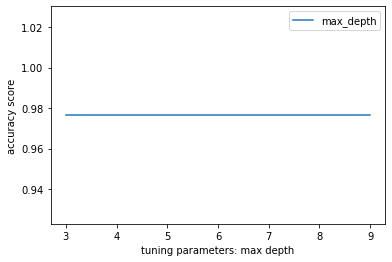

In [9]:
import matplotlib.pyplot as plt
plt.plot(md,rfs,label='max_depth')
plt.xlabel('tuning parameters: max depth')
plt.ylabel('accuracy score')
plt.legend()

Tree depth did not made a difference at all. Ptobably because of the imbalanced dataset (many more 0's than 1's).

In [10]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1000, max_depth = 6)
rf.fit(X_tr, y_tr)
rf_pred = rf.predict(X_te)

Confusion matrix

In [20]:
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_te,rf_pred), columns = ['y_te positive','y_te Negative'])
cm['Prediction'] = pd.Series(['y_pred positive','y_pred negative'])
cm = cm[['Prediction','y_te positive','y_te Negative']]
cm = cm.set_index('Prediction')
cm

,y_te positive,y_te Negative
Prediction,,
y_pred positive,7369468,0
y_pred negative,231657,0


In [23]:
cm.to_csv("RF_ConfMat.csv")